In [62]:
from __future__ import annotations

import ast
import typing as T
import collections.abc as C
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

In [63]:
def load_dataset(filepath: str) -> pd.DataFrame:
    def parse_values(x: pd.Series) -> pd.Series:
        keys = ast.literal_eval(x.loc["keys"])[0]
        values = (
            float(x) if x != "null" else pd.NA
            for x in ast.literal_eval(x.loc["values"])[0]
        )
        return pd.Series(dict(zip(keys, values)))

    df = pd.read_csv(filepath, parse_dates=[2], index_col=0)
    values = df.apply(parse_values, axis=1)
    df = pd.concat([df[["configuration_item_id", "ts"]], values], axis=1)
    return df.convert_dtypes()

In [64]:
X_train = load_dataset("data/train999.csv")
X_train

,configuration_item_id,ts,meteo_layer_type,meteo_cloudiness,meteo_wind_velocity,meteo_humidity,meteo_t_underroad,meteo_freezing_point,meteo_wind_direction,meteo_dew_point,meteo_t_road,meteo_wind_gusts,meteo_t_air,meteo_air_pressure
id,,,,,,,,,,,,,,
1684,30928,2024-06-29 03:00:01,1.0,3,2.3,46.7,41.4,0.0,132,16.9,35.1,4.2,29.5,733
862,30928,2024-06-10 11:00:00,1.0,2,2.5,29.4,32.1,0.0,351,3.3,30.3,4.4,22.0,737
1992,24445,2024-05-26 22:00:02,1.0,2,0.5,70.8,21.8,0.0,121,-4.7,18.6,1.1,0.0,754
889,30928,2024-06-11 01:00:59,1.0,3,2.5,61.6,25.7,0.0,63,11.2,20.7,4.2,18.7,736
1362,30928,2024-06-22 02:00:00,1.0,4,2.8,61.5,27.5,0.0,185,14.9,22.2,6.0,22.7,733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,30928,2024-06-28 02:30:01,1.0,2,2.1,58.7,39.1,0.0,82,18.6,33.3,4.2,27.4,736
1095,30928,2024-06-15 23:30:01,1.0,3,0.5,60.7,27.0,0.0,205,15.4,24.0,1.9,23.4,736
1130,30928,2024-06-16 18:30:00,1.0,3,1.2,90.1,26.0,0.0,231,17.3,26.0,2.4,18.9,734


In [65]:
_, station_1 = next(iter(X_train.groupby("configuration_item_id")))

,ts,meteo_wind_velocity,anomaly
id,,,
1992,2024-05-26 22:00:02,0.5,1
2023,2024-05-28 05:30:00,5.2,-1
2646,2024-06-25 08:30:01,5.3,-1
1798,2024-05-14 03:00:01,2.5,1
2194,2024-06-06 13:30:03,0.8,1
...,...,...,...
2324,2024-06-11 19:30:02,0.7,1
2433,2024-06-16 09:00:02,4.4,1
2391,2024-06-14 17:30:00,1.1,1


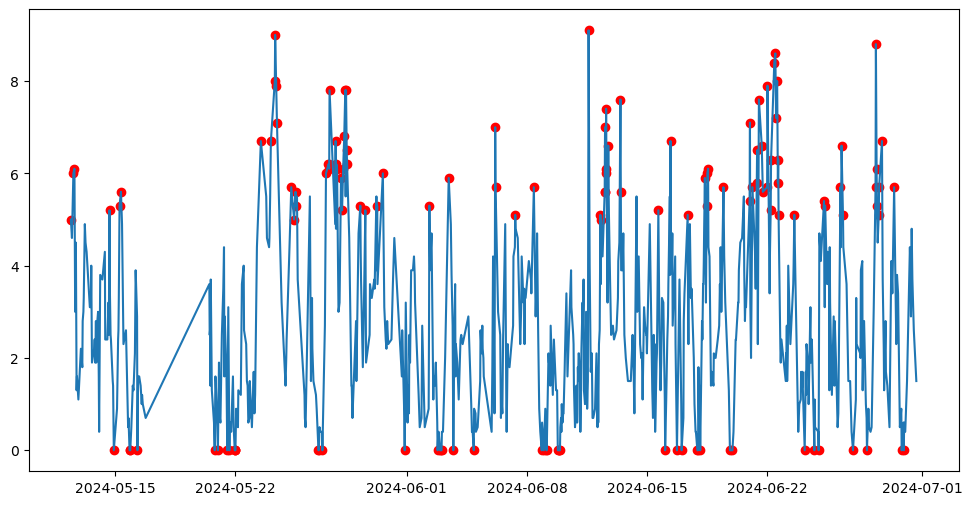

In [66]:
col = "meteo_wind_velocity"
contamination = 0.2

df = pd.DataFrame(station_1[["ts", col]])

scaler = StandardScaler()
scaled = scaler.fit_transform(df[col].values.reshape(-1, 1))  # type: ignore
data = pd.DataFrame(scaled)
model = IsolationForest(contamination=contamination)
model.fit(data)

df = df.assign(anomaly=model.predict(data))

pl = df.set_index("ts").sort_index()
# plotted = plotted.loc["2024-06-01":"2024-06-08"]

fig, ax = plt.subplots(figsize=(12, 6))
a = pl.loc[pl["anomaly"] == -1, [col]]

ax.plot(pl.index, pl[col], label="normal")
ax.scatter(a.index, a[col], color="red", label="Anomaly")
df

In [67]:
def detect_anomalies(df: pd.DataFrame, contaminations: dict[str, str | float]):
    df = df.copy()
    meteo_cols = [
        (str(col), series) for col, series in df.items() if str(col).startswith("meteo")
    ]

    for col, s in meteo_cols:
        if s.isna().sum() > 0:
            df[f"anomaly_{col}"] = df.isna().map(int)
        else:
            scaler = StandardScaler()
            scaled = scaler.fit_transform(s.values.reshape(-1, 1))  # type: ignore
            data = pd.DataFrame(scaled)

            model = IsolationForest(contamination=contaminations[col])
            model.fit(data)

            df[f"anomaly_{col}"] = model.predict(data)
            df[f"anomaly_{col}"] = df[f"anomaly_{col}"].map({1: 0, -1: 1})

    return df

In [73]:
def plot_anomalies(df: pd.DataFrame):
    anomaly_cols = [x for x in df.columns if x.startswith("anomaly")]
    plot_count = len(anomaly_cols)

    fig, axes = plt.subplots(plot_count, figsize=(12, 6 * plot_count))
    axes = axes.flat
    axes = T.cast(C.Sequence[Axes], axes)

    for anomaly_name, ax in zip(anomaly_cols, axes):
        col = anomaly_name[len("anomaly_") :]
        a = df.loc[df[anomaly_name] == 1, [col]]

        ax.plot(df.index, df[col], label=col)
        ax.scatter(a.index, a[col], color="red", label="anomaly")
        ax.legend(loc="upper left")

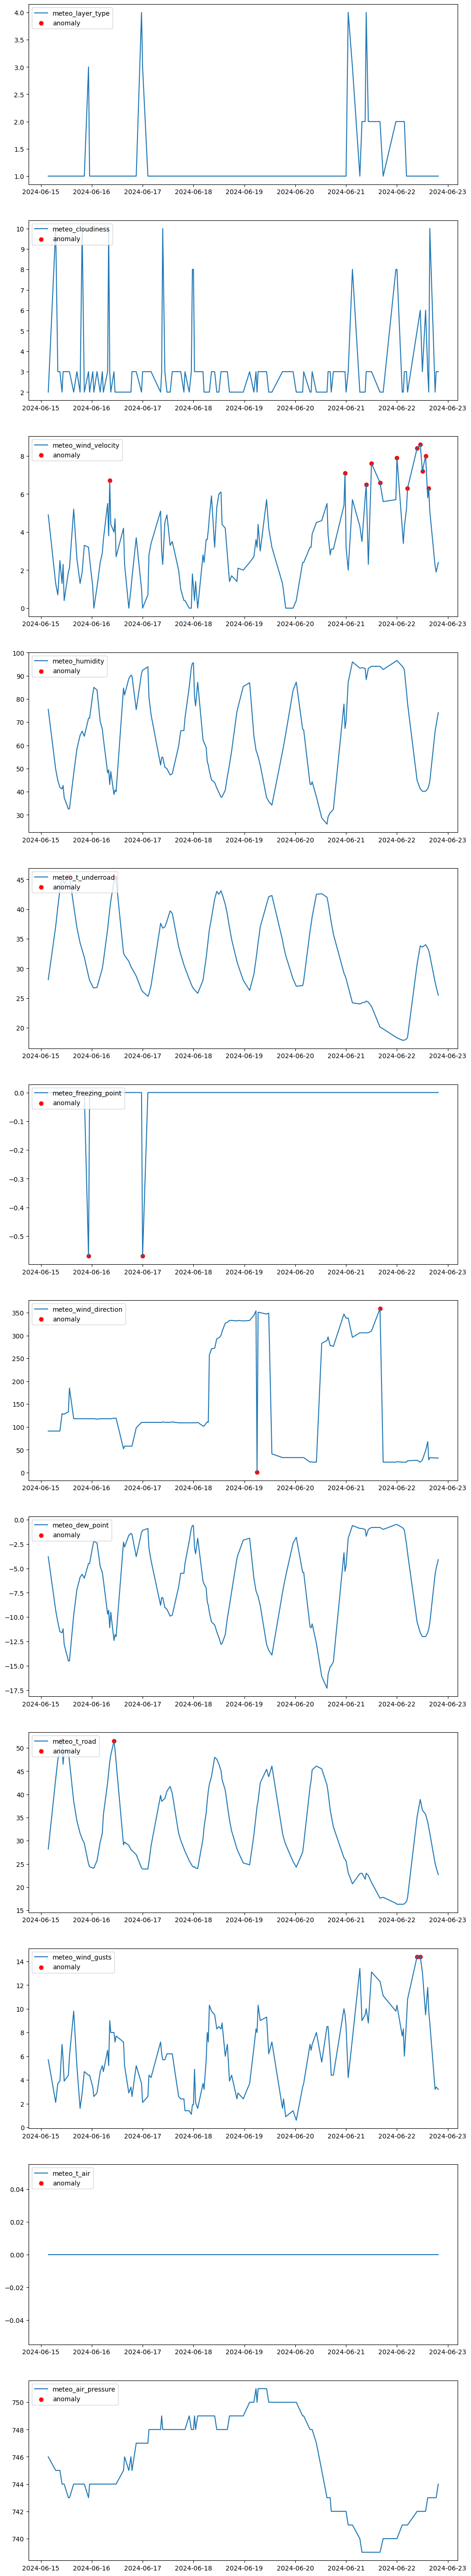

In [91]:
contaminations: dict[str, str | float] = defaultdict(lambda: 0.01, {
    "meteo_layer_type": 0.005,
    "meteo_wind_velocity": 0.1,
    "meteo_wind_direction": 0.01,
    "meteo"
})

anomalies = detect_anomalies(station_1, contaminations)

pl = anomalies.set_index("ts").sort_index()
pl = pl.loc["2024-06-15":"2024-06-22"]

plot_anomalies(pl)

In [21]:
skipped_meteo_cols = [
    c for c in df.columns if c.startswith("meteo") and f"anomaly_{c}" not in df.columns
]

filled_df = df.copy()
for col in skipped_meteo_cols:
    filled_df[f"anomaly_{col}"] = df[col].isna().map({True: -1, False: 1})

skipped_meteo_cols

[]

In [22]:
meteo_cols = [col for col in filled_df.columns if col.startswith("meteo")]
sorted_anomaly_cols = sorted(
    (x for x in df.columns if x.startswith("anomaly")),
    key=lambda a: meteo_cols.index(a[len("anomaly_") :]),
)
sorted_anomaly_cols

['anomaly_meteo_layer_type',
 'anomaly_meteo_cloudiness',
 'anomaly_meteo_wind_velocity',
 'anomaly_meteo_humidity',
 'anomaly_meteo_t_underroad',
 'anomaly_meteo_freezing_point',
 'anomaly_meteo_wind_direction',
 'anomaly_meteo_dew_point',
 'anomaly_meteo_t_road',
 'anomaly_meteo_wind_gusts',
 'anomaly_meteo_t_air',
 'anomaly_meteo_air_pressure']

In [23]:
result = df[["id", *sorted_anomaly_cols]].set_index("id")
result = result.replace({1: 0, -1: 1})
result

,anomaly_meteo_layer_type,anomaly_meteo_cloudiness,anomaly_meteo_wind_velocity,anomaly_meteo_humidity,anomaly_meteo_t_underroad,anomaly_meteo_freezing_point,anomaly_meteo_wind_direction,anomaly_meteo_dew_point,anomaly_meteo_t_road,anomaly_meteo_wind_gusts,anomaly_meteo_t_air,anomaly_meteo_air_pressure
id,,,,,,,,,,,,
2080,0,0,0,0,0,0,1,0,0,0,0,0
2081,0,0,0,0,0,0,1,0,0,0,0,0
2082,0,0,0,0,0,0,1,0,0,0,0,0
2083,0,0,0,0,0,0,0,0,0,0,0,0
2084,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2239,0,0,0,0,0,0,0,0,0,0,0,0
2241,0,0,0,0,0,0,0,0,0,0,0,0
2242,0,0,0,0,0,0,0,0,0,1,0,0


In [15]:
result["target"] = result.agg(lambda x: "[%s]" % ", ".join(map(str, x)), axis=1)
result["target"].to_csv("out/targets-train-isolation-1.csv")

In [37]:
def fill_skipped(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    skipped_meteo_cols = [
        c
        for c in df.columns
        if c.startswith("meteo") and f"anomaly_{c}" not in df.columns
    ]
    for col in skipped_meteo_cols:
        df[f"anomaly_{col}"] = df[col].isna().map({True: -1, False: 1})
    return df

def compile_results(df: pd.DataFrame) -> pd.DataFrame:
    meteo_cols = [col for col in df.columns if col.startswith("meteo")]
    sorted_anomaly_cols = sorted(
        (x for x in df.columns if x.startswith("anomaly")),
        key=lambda a: meteo_cols.index(a[len("anomaly_") :]),
    )
    
    result = df[["id", *sorted_anomaly_cols]].set_index("id")
    result = result.replace({1: 0, -1: 1})
    result["target"] = result.agg(lambda x: "[%s]" % ", ".join(map(str, x)), axis=1)

    return result

In [40]:
def run_dataset(dataset: pd.DataFrame):
    results: list[pd.DataFrame] = []
    for station, df in dataset.groupby("configuration_item_id"):
        anomalies = detect_anomalies(df)
        filled = fill_skipped(anomalies)
        results.append(compile_results(filled))
    return pd.concat(results)["target"]